In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import torch
from torchseis import FaultSSL, FaultPipeline, FaultSeg3d, FaultSeg3dPlus
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
def ramp(cmap, blow=0, up=1, alpha_min=0, alpha_max=1):
    """
    Creates a modified colormap from an existing colormap, with adjustable transparency (alpha) levels.
    
    Parameters:
    - cmap: The original colormap to be modified.
    - blow (float, optional): The lower bound of the colormap normalization range. Defaults to 0.
    - up (float, optional): The upper bound of the colormap normalization range. Defaults to 1.
    - alpha_min (float, optional): The minimum alpha (transparency) value to apply. Defaults to 0.
    - alpha_max (float, optional): The maximum alpha (transparency) value to apply. Defaults to 1.
    
    Returns:
    - A new colormap with alpha adjusted from alpha_min to alpha_max within the specified range [blow, up].
    """

    cmap = plt.get_cmap(cmap)
    slope = (alpha_max - alpha_min) / (up - blow)
    N = cmap.N
    arr = cmap(np.arange(N))
    istart = int(blow * N)
    iend = int(up * N)
    arr[:istart, 3] = alpha_min
    arr[iend:, 3] = alpha_max
    arr[istart:iend, 3] = np.arange(iend - istart) / N * slope + alpha_min
    cmap = ListedColormap(arr)
    return cmap

In [4]:
d = np.fromfile('/wzg2/data/gsbcut_h1001x2622x555.dat', np.float32).reshape(555, 2622, 1001)
print(d.shape)

(555, 2622, 1001)


(555, 2622, 412)


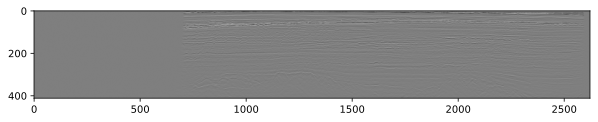

In [5]:
x = d[:, :, 100:512]
print(x.shape)
x = (x - x.mean()) / x.std() # No need to do, as I implemet this in Pipeline

plt.figure(figsize=(10, 10))
plt.imshow(x[250, :, :].T, cmap='gray', vmin=-3, vmax=3)
plt.show()

In [7]:
fssl_iou = FaultSSL(mode='iou').eval()
params = torch.load('pretrained/fault/faultssl/IOUFirst.pt', weights_only=True)
fssl_iou.load_state_dict(params)
fssl_iou = fssl_iou.half().cuda()

ssl_iou_p = FaultPipeline(fssl_iou).half().cuda()
y1 = ssl_iou_p(x, 2)

In [8]:
fssl_pre = FaultSSL(mode='precision').eval()
params = torch.load('pretrained/fault/faultssl/PrecisionFirst.pt', weights_only=True)
fssl_pre.load_state_dict(params)
fssl_pre = fssl_pre.cuda().half()

ssl_pre_p = FaultPipeline(fssl_pre).half().cuda()
y2 = ssl_pre_p(x, 2)

In [9]:
f3d = FaultSeg3d().eval()
params = torch.load('pretrained/fault/faultseg3d/faultseg3d-2020-70.pt', weights_only=True)
f3d.load_state_dict(params)
f3d = f3d.cuda().half()

f3d_p = FaultPipeline(f3d).half().cuda()
y3 = f3d_p(x, 3)

In [10]:
f3dp = FaultSeg3dPlus().eval()
params = torch.load('pretrained/fault/faultseg3dplus/faultseg3dplus.pt', weights_only=True)
f3dp.load_state_dict(params)
f3dp = f3dp.cuda().half()

f3dp_p = FaultPipeline(f3dp).half().cuda()
y4 = f3dp_p(x, 3)

In [11]:
y4.shape

(555, 2622, 412)

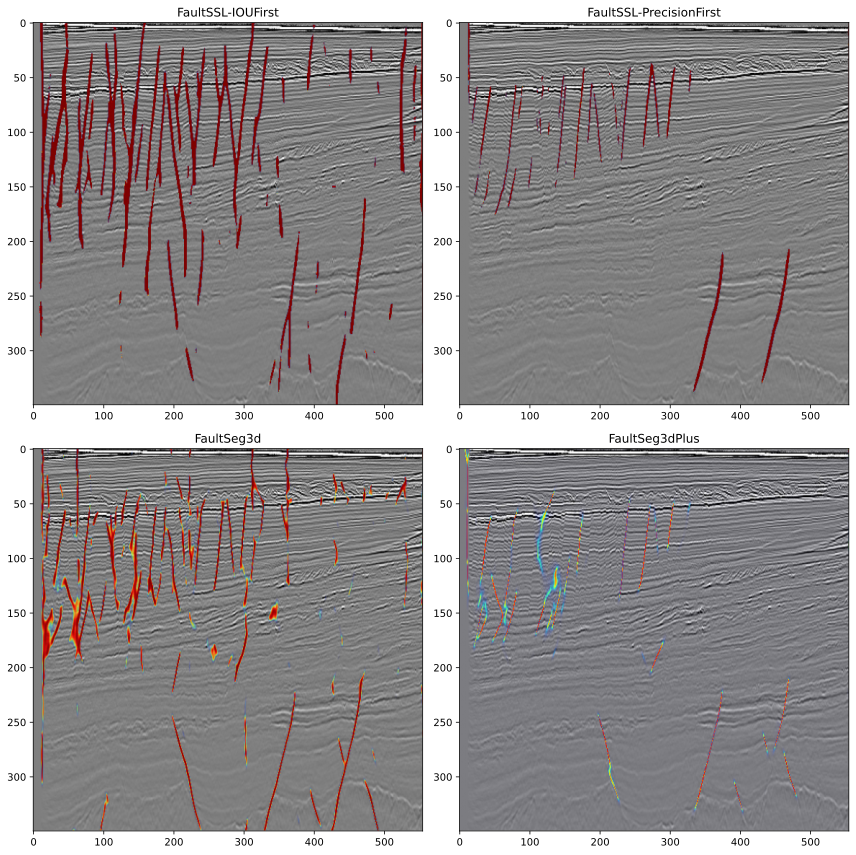

In [12]:
# x = (x - x.mean()) / x.std()
cmap = ramp('jet')
cmap2 = ramp('jet', 0.11, 0.5)
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flat
index = (slice(None), 1500, slice(None,350))
ax[0].imshow(x[index].T, cmap='gray', vmin=-3, vmax=3, aspect='auto')
ax[0].imshow(y1[index].T, cmap=cmap, aspect='auto')
ax[0].set_title("FaultSSL-IOUFirst")
ax[1].imshow(x[index].T, cmap='gray', vmin=-3, vmax=3, aspect='auto')
ax[1].imshow(y2[index].T, cmap=cmap, aspect='auto')
ax[1].set_title("FaultSSL-PrecisionFirst")
ax[2].imshow(x[index].T, cmap='gray', vmin=-3, vmax=3, aspect='auto')
ax[2].imshow(y3[index].T, cmap=cmap, aspect='auto')
ax[2].set_title("FaultSeg3d")
ax[3].imshow(x[index].T, cmap='gray', vmin=-3, vmax=3, aspect='auto')
ax[3].imshow(y4[index].T, cmap=cmap2, aspect='auto')
ax[3].set_title("FaultSeg3dPlus")


plt.tight_layout()
plt.show()

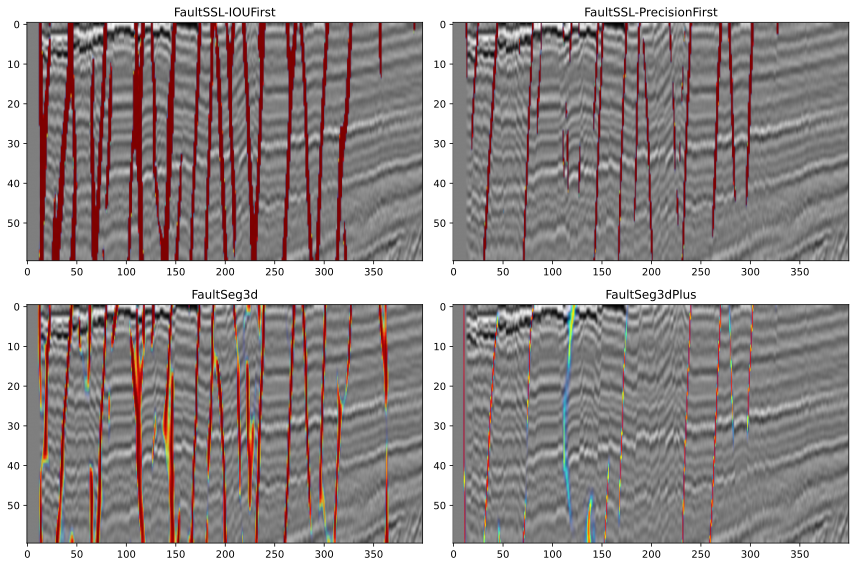

In [13]:
cmap = ramp('jet')
cmap2 = ramp('jet', 0.11, 0.5)
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.flat
index = (slice(None,400), 1500, slice(60,120))
ax[0].imshow(x[index].T, cmap='gray', vmin=-3, vmax=3, aspect='auto', interpolation='bicubic')
ax[0].imshow(y1[index].T, cmap=cmap, aspect='auto')
ax[0].set_title("FaultSSL-IOUFirst")
ax[1].imshow(x[index].T, cmap='gray', vmin=-3, vmax=3, aspect='auto', interpolation='bicubic')
ax[1].imshow(y2[index].T, cmap=cmap, aspect='auto')
ax[1].set_title("FaultSSL-PrecisionFirst")
ax[2].imshow(x[index].T, cmap='gray', vmin=-3, vmax=3, aspect='auto', interpolation='bicubic')
ax[2].imshow(y3[index].T, cmap=cmap, aspect='auto')
ax[2].set_title("FaultSeg3d")
ax[3].imshow(x[index].T, cmap='gray', vmin=-3, vmax=3, aspect='auto', interpolation='bicubic')
ax[3].imshow(y4[index].T, cmap=cmap2, aspect='auto')
ax[3].set_title("FaultSeg3dPlus")


plt.tight_layout()
plt.show()